Epigenetic Reader Protein Binding  
============================

Self-consistent field theory for multiple marks
------------------------------------------------------

In [170]:
import sys
sys.path.insert(1, './wlcstat/')
import numpy as np
import scipy.special as sp
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [205]:
def eval_f_bind(n_b, n_m, e_m = -1.5, j_int = -3.92):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        Number of reader proteins bound to the nucleosome
    n_m : integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind = 0

    if n_b == 0:
        f_bind = 0
    elif n_b == 1:
        if n_m == 0:
            f_bind = -np.log(2)
        elif n_m == 1:
            f_bind = -np.log(1. + np.exp(-e_m))
        elif n_m == 2:
            f_bind = e_m - np.log(2)
    elif n_b == 2:
        if n_m == 0:
            f_bind = j_int
        elif n_m == 1:
            f_bind = e_m + j_int
        elif n_m == 2:
            f_bind = 2 * e_m + j_int
    
    return f_bind

def eval_opt_func(x, mu, e_m, v_int, f_om, phi_c):
    r"""
    eval_opt_func - Evaluate the binding state for 
    
    """

    # Convert to average bound variable and phi variable
    n_bind = len(mu) # number of reader protein types
    s_bind = 2. * np.exp(x) / (1 + np.exp(x))
    
    phi_bind = np.zeros(n_bind)
    for mark in range(n_bind):
        ind0 = mark * 3 
#         phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 2)] * s_bind[ind0:(ind0 + 2)]) # ORGINAL. OBOE
        phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)]) # MINE
    erg_int = np.matmul(v_int, phi_bind)
    
    # Evaluate the optimization function
    opt_func = np.zeros(n_bind * 3)
    
    ind = 0
    for mark in range(n_bind): # for each reader protein/ mark type
        for om in range(3): # for each possible number of marked tails on nucl
            f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
            f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
            q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])
            #calculate the difference b/w new and previous avg binding state 
            # FOR opt.fsolve:
            opt_func[ind] = s_bind[ind] - (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
                                             2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q        
#             # FOR opt.minimize
#             opt_func[ind] = (s_bind[ind] - (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
#                                              2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q)**2                     
    
            ind += 1
    
    return opt_func

def eval_s_bind(mu, e_m, v_int, f_om, phi_c, x0, mu_fail_arr):
    # Convert to average bound variable and phi variable
    n_bind = len(mu)
    for mark in range(n_bind):
        ind0 = mark * 3
#         indf = ind0 + 2 # ORGINAL OBOE
        indf = ind0 + 3 # MINE
        f_om[ind0:indf] /= np.sum(f_om[ind0:indf])
    
    x = np.zeros(n_bind * 3)
    
    data = [mu, e_m, v_int, f_om, phi_c]

    #doing unbounded non-linear solver for x, then calc (bounded) var s_bind
    x = opt.root(eval_opt_func, x0=x0, args=tuple(data))
#
    suc = x.success
    msg = x.message
    x = x.x
    
    test = eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)
    if  not suc:
        
#         print("failure at mu = ", str(mu))
#         print("test: ", test)
#         print("suc: ", suc)
#         print(msg)
#         print("------------------")
        
        mu_fail_arr= np.append(mu, mu_fail_arr)
        return [np.nan]*n_bind*3, mu_fail_arr
    
    s_bind = 2. * np.exp(x) / (1 + np.exp(x))
    
    return s_bind, mu_fail_arr

## Langmuir isotherm analysis single protein

In [172]:
n_bind = 1 #types of proteins/marks

e_m = np.array([-1.5]) #binding energy
# e_m = np.array([-8.5]) #binding energy
# e_m = np.array([0]) #binding energy
f_om = np.array([1/3, 1/3, 1/3]) # fraction of nucleosomes with 0,1,2 marks per protein type
# v_int = np.array([[-3.92]]) # protein-protein interaction param
# v_int = np.array([[-1.8]]) # protein-protein interaction param
v_int = np.array([[-8]])
phi_c = 0.6# avg amount of chromosome 

x = np.zeros(n_bind * 3)

In [167]:
# MULTIPLE STARTING CONDITIONS, UNBOUNDED
 
mu_array = np.arange(-10, 10, .1)
# mu_array = np.arange(-8, -3, 1)
mul = len(mu_array)
ones = np.ones(n_bind * 3)
x0_min = -4
x0_mid = 0
x0_max = 4

x0_arr = np.array([ones * x0_min, ones * x0_mid, ones*x0_mid, ones * x0_max])

mu_mid = -5.25
# mu_mid = -9


mu_arrs = [mu_array, mu_array[np.where(mu_array >= mu_mid)], \
           mu_array[np.where(mu_array <= mu_mid)][::-1], mu_array[::-1]]

mu_fail_arr_arr = np.zeros(len(x0_arr), dtype = object)
f_bar_arr_arr = np.zeros(len(x0_arr), dtype = object)

for j,x0 in enumerate(x0_arr):
    mu_ar = mu_arrs[j]
#     print(j)
#     print("mu arr [0]: ", mu_ar[0])
#     print("x0[0] = ", x0[0])
    f_bar_arr = np.zeros(len(mu_ar))
    s_bind_0sig = np.zeros(len(mu_ar))
    s_bind_1sig = np.zeros(len(mu_ar))
    s_bind_2sig = np.zeros(len(mu_ar)) 
    mu_fail_arr = np.array([])
    x00 = x0
    for i,mu in enumerate(mu_ar):
        s_bind, mu_fail_arr = eval_s_bind([mu], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
        f_bar = np.sum(f_om * s_bind)
        s_bind_0sig[i] = s_bind[0]
        s_bind_1sig[i] = s_bind[1]
        s_bind_2sig[i] = s_bind[2]
        f_bar_arr[i] = f_bar
        if s_bind[0] is not np.nan:
            x00 = -np.log( (2/s_bind) - 1)
   
    f_bar_arr_arr[j] = f_bar_arr
    mu_fail_arr_arr[j] = mu_fail_arr
#     print("xxxxxxxxxx end of one iter xxxx")

C:\Users\tmhab\AppData\Local\Temp\ipykernel_4632\4162760159.py:50: RuntimeWarning: overflow encountered in exp
  s_bind = 2. * np.exp(x) / (1 + np.exp(x))
C:\Users\tmhab\AppData\Local\Temp\ipykernel_4632\4162760159.py:50: RuntimeWarning: invalid value encountered in divide
  s_bind = 2. * np.exp(x) / (1 + np.exp(x))


In [168]:
# MULTIPLE STARTING CONDITIONS, UNBOUNDED
# adaptive mu_mid
 
mu_array = np.arange(-10, 10, .1)
# mu_array = np.arange(-8, -3, 1)
mul = len(mu_array)
ones = np.ones(n_bind * 3)
x0_min = -4
x0_mid = 0
x0_max = 4

x0_arr = np.array([ones*x0_min, ones*x0_max, ones*x0_mid, ones*x0_mid])

# mu_mid = -5.25
# mu_mid = -9


mu_fail_arr_arr = np.zeros(len(x0_arr), dtype = object)
f_bar_arr_arr = np.zeros(len(x0_arr), dtype = object)

####
mu_arrs_full = [mu_array, mu_array[::-1]]
x0_arr_full = np.array([ones * x0_min, ones * x0_max])




for j,x0 in enumerate(x0_arr_full):
    mu_ar = mu_arrs_full[j]
#     print(j)
#     print("mu arr [0]: ", mu_ar[0])
#     print("x0[0] = ", x0[0])
    f_bar_arr = np.zeros(len(mu_ar))
    s_bind_0sig = np.zeros(len(mu_ar))
    s_bind_1sig = np.zeros(len(mu_ar))
    s_bind_2sig = np.zeros(len(mu_ar)) 
    mu_fail_arr = np.array([])
    x00 = x0
    for i,mu in enumerate(mu_ar):
        s_bind, mu_fail_arr = eval_s_bind([mu], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
        f_bar = np.sum(f_om * s_bind)
        s_bind_0sig[i] = s_bind[0]
        s_bind_1sig[i] = s_bind[1]
        s_bind_2sig[i] = s_bind[2]
        f_bar_arr[i] = f_bar
        if s_bind[0] is not np.nan:
            x00 = -np.log( (2/s_bind) - 1)
   
    f_bar_arr_arr[j] = f_bar_arr
    mu_fail_arr_arr[j] = mu_fail_arr
#     print("xxxxxxxxxx end of one iter xxxx")

f_bar_scan1 = f_bar_arr_arr[0]
f_bar_scan1 = f_bar_scan1[~np.isnan(f_bar_scan1)]
f_bar_scan2 = f_bar_arr_arr[1]
f_bar_scan2 = f_bar_scan2[~np.isnan(f_bar_scan2)]

diff1 = np.abs(np.diff(f_bar_scan1))
diff2 = np.abs(np.diff(f_bar_scan2))
mu_jump1 = np.where(diff1==np.max(diff1))[0][0]
mu_jump2 = np.where(diff2==np.max(diff2))[0][0]

mu_mid = (mu_arrs_full[0][mu_jump1] + mu_arrs_full[1][mu_jump2]) / 2


mu_arrs_mid = [mu_array[np.where(mu_array >= mu_mid)], \
           mu_array[np.where(mu_array <= mu_mid)][::-1]]
x0_arr_mid = np.array([ones * x0_mid, ones*x0_mid])

mu_arrs = [mu_array, mu_array[::-1], mu_array[np.where(mu_array >= mu_mid)], \
           mu_array[np.where(mu_array <= mu_mid)][::-1]]

for j,x0 in enumerate(x0_arr_mid):
    mu_ar = mu_arrs_mid[j]
#     print(j)
#     print("mu arr [0]: ", mu_ar[0])
#     print("x0[0] = ", x0[0])
    f_bar_arr = np.zeros(len(mu_ar))
    s_bind_0sig = np.zeros(len(mu_ar))
    s_bind_1sig = np.zeros(len(mu_ar))
    s_bind_2sig = np.zeros(len(mu_ar)) 
    mu_fail_arr = np.array([])
    x00 = x0
    for i,mu in enumerate(mu_ar):
        s_bind, mu_fail_arr = eval_s_bind([mu], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
        f_bar = np.sum(f_om * s_bind)
        s_bind_0sig[i] = s_bind[0]
        s_bind_1sig[i] = s_bind[1]
        s_bind_2sig[i] = s_bind[2]
        f_bar_arr[i] = f_bar
        if s_bind[0] is not np.nan:
            x00 = -np.log( (2/s_bind) - 1)
   
    f_bar_arr_arr[j+2] = f_bar_arr
    mu_fail_arr_arr[j+2] = mu_fail_arr
#     print("xxxxxxxxxx end of one iter xxxx")

# mum = [0,1,2,3,4,5]
# ss1 = [0, 0.5, 1, 30, 40]  
# ss2 = [0, 0.5, 20, 25, 30]
# mum_mid_1 = np.where(np.diff(ss1)==np.max(np.diff(ss1)))
# mum_mid_2 = np.where(np.diff(ss2)==np.max(np.diff(ss2)))

C:\Users\tmhab\AppData\Local\Temp\ipykernel_4632\4162760159.py:50: RuntimeWarning: overflow encountered in exp
  s_bind = 2. * np.exp(x) / (1 + np.exp(x))
C:\Users\tmhab\AppData\Local\Temp\ipykernel_4632\4162760159.py:50: RuntimeWarning: invalid value encountered in divide
  s_bind = 2. * np.exp(x) / (1 + np.exp(x))


<Figure size 640x480 with 0 Axes>

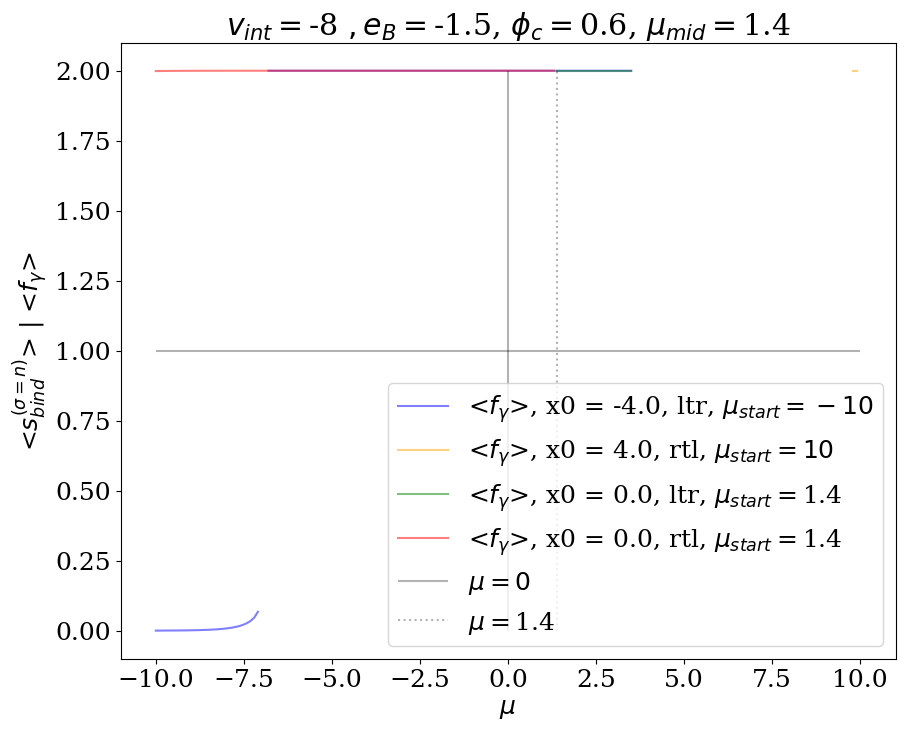

In [169]:
#for adaptive mu_mid
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
# lins = ["-", ":", "-.", "--"]
# lins_bnd = [":", "-", "--", "-."]
lins = ["-"]*6

colors = ["blue","orange","green","red", "pink", "purple"]
for j,x0 in enumerate(x0_arr[:]):
    if j == 0 or j ==2:
        msg = ", ltr"
    else:
        msg = ", rtl"
    if j == 2 or j == 3:
        msg2 = ", $\mu_{start} = $"+ str(np.round(mu_mid,3))
    elif j ==0:
        msg2 =  ", $\mu_{start} = -10$"
    elif j ==1:
         msg2 = ", $\mu_{start} = 10$"
            
#     if x0[0] > -2 and x0[0] < 2:
#     if j ==1:
    plt.plot(mu_arrs[j], f_bar_arr_arr[j], label = "<$ f_{\gamma} $>, x0 = " + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
#         plt.vlines(mu_fail_arr_arr[j], 0,2,color = colors[j])


plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
plt.xlabel("$\mu$")
plt.title("$v_{int} = $" + str(v_int[0][0]) +  " $,e_B = $" + str(e_m[0]) + ", $\phi_c = $" + str(phi_c) +", $\mu_{mid} = $" + str(np.round(mu_mid,3)))
plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
plt.vlines(mu_mid, 0,2, color = "black", alpha = 0.3, label = "$\mu = $" + str(np.round(mu_mid,3)), linestyle = ":")
plt.legend()

# why is s_bind = 2 * (exp(x \ (1 + exp)))? how did that realtion come about. it is to allow for unbounded minimizationq
#check solver- intial conditions? 

In [ ]:
# #for non-adaptive mu_mid
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)
# # lins = ["-", ":", "-.", "--"]
# # lins_bnd = [":", "-", "--", "-."]
# lins = ["-"]*6

# colors = ["blue","orange","green","red", "pink", "purple"]
# for j,x0 in enumerate(x0_arr[:]):
#     if j <= 1:
#         msg = ", ltr"
#     else:
#         msg = ", rtl"
#     if j == 1 or j == 2:
#         msg2 = ", $\mu_{start} = $"+ str(np.round(mu_mid,3))
#     elif j ==0:
#         msg2 =  ", $\mu_{start} = -10$"
#     elif j ==3:
#          msg2 = ", $\mu_{start} = 10$"
            
# #     if x0[0] > -2 and x0[0] < 2:
# #     if j ==3 or j == 3 :
#     plt.plot(mu_arrs[j], f_bar_arr_arr[j], label = "<$ f_{\gamma} $>, x0 = " + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
#     plt.vlines(mu_fail_arr_arr[j], 0,2,color = colors[j])


# plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
# plt.xlabel("$\mu$")
# plt.title("$v_{int} = $" + str(v_int[0][0]) +  " $,e_B = $" + str(e_m[0]) + ", $\phi_c = $" + str(phi_c) +", $\mu_{mid} = $" + str(np.round(mu_mid,3)))
# plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# # plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
# plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
# plt.vlines(mu_mid, 0,2, color = "black", alpha = 0.3, label = "$\mu = $" + str(np.round(mu_mid,3)), linestyle = ":")
# plt.legend()

# # why is s_bind = 2 * (exp(x \ (1 + exp)))? how did that realtion come about. it is to allow for unbounded minimizationq
# #check solver- intial conditions? 

## Langmuir isotherm analysis two proteins

In [256]:
n_bind = 2 #types of proteins/marks

# e_m = np.array([-1.5, -1.5]) #binding energy
e_m = np.array([0,-1.5]) #binding energy
f_om = np.array([1/3, 1/3, 1/3, 1/3, 1/3, 1/3]) # fraction of nucleosomes with 0,1,2 marks per protein type
v_int = np.array([[-3.92, 3.0],[3.0, -3.92]])
# v_int = np.array([[-1,1],[1,-1]]) # protein-protein interaction param
# v_int = np.array([[0,0],[0,0]]) # protein-protein interaction param
phi_c = 1# avg amount of chromosome 

x = np.zeros(n_bind * 3)

# eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)

In [257]:
# TODO implement multiple scans wrt mu1, and using previous s_bind as next s_bind

mu1_array = np.arange(-10, 10, .1)
mu2_array = [0,10,-10]#np.arange(-10, 10, .1)

mul = len(mu1_array)

ones = np.ones(n_bind * 3)
x0_min = -4
x0_mid = 0
x0_max = 4
x0_arr = np.array([ones * x0_min, ones * x0_mid, ones*x0_mid, ones * x0_max])

mu_mid = -5.25


mu_arrs = [mu1_array, mu1_array[np.where(mu1_array >= mu_mid)], \
           mu1_array[np.where(mu1_array <= mu_mid)][::-1], mu1_array[::-1]]

f_bar_arr_arr = np.zeros(len(x0_arr), dtype = object)
# f_bar1_arr = np.zeros((len(mu1_array), len(mu2_array)))
# f_bar2_arr = np.zeros((len(mu1_array), len(mu2_array)))
# f_bar_arrs = [f_bar1_arr, f_bar2_arr]

# s_bind1_0sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind1_1sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind1_2sig = np.zeros((len(mu1_array), len(mu2_array)))

# s_bind2_0sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind2_1sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind2_2sig = np.zeros((len(mu1_array), len(mu2_array)))

for k,x0 in enumerate(x0_arr):
    mu_ar = mu_arrs[k]
    f_bar1_arr = np.zeros((len(mu_ar), len(mu2_array)))
    f_bar2_arr = np.zeros((len(mu_ar), len(mu2_array)))
    f_bar_arrs = np.array([f_bar1_arr, f_bar2_arr])
#     x00 = x0
#     if k == 0:
#         print(x00)
#     for i, mu1 in enumerate(mu_ar):
#         for j, mu2 in enumerate(mu2_array): # ORIG

    for j, mu2 in enumerate(mu2_array):
        x00 = x0
        for i, mu1 in enumerate(mu_ar):
#             print(x00)
            s_bind, mu_fail_arr = eval_s_bind([mu1, mu2], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
#             if k == 0:
#                 print()
#                 print("S_bind: ", s_bind)
#                 print("mu_2: ", mu2)
#                 print("mu_1:", mu1)
#                 print(x00)

            for mark in range(n_bind):
                f_bar_array = f_bar_arrs[mark]
                ind0 = mark * 3
                f_bar_array[i,j] = np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)])
                f_bar_arrs[mark] = f_bar_array
            if s_bind[0] is not np.nan:
                x00 = -np.log( (2/s_bind) - 1)

#             s_bind1_0sig[i,j] = s_bind[0]
#             s_bind1_1sig[i,j] = s_bind[1]
#             s_bind1_2sig[i,j] = s_bind[2]

#             s_bind2_0sig[i,j] = s_bind[3]
#             s_bind2_1sig[i,j] = s_bind[4]
#             s_bind2_2sig[i,j] = s_bind[5]
    f_bar_arr_arr[k] = f_bar_arrs
#     f_bar1_arr = f_bar_arrs[0]
#     f_bar2_arr = f_bar_arrs[1]

C:\Users\tmhab\AppData\Local\Temp\ipykernel_4632\3513860877.py:50: RuntimeWarning: overflow encountered in exp
  s_bind = 2. * np.exp(x) / (1 + np.exp(x))
C:\Users\tmhab\AppData\Local\Temp\ipykernel_4632\3513860877.py:50: RuntimeWarning: invalid value encountered in divide
  s_bind = 2. * np.exp(x) / (1 + np.exp(x))
C:\Users\tmhab\AppData\Local\Temp\ipykernel_4632\1747710466.py:62: RuntimeWarning: divide by zero encountered in log
  x00 = -np.log( (2/s_bind) - 1)


In [239]:
x00 = [0]*6
mu1 = 0
mu2 = -10
eval_s_bind([mu1, mu2], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)

(array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.07957374e-05,
        2.48824847e-04, 4.06853956e-04]),
 array([-10., -10., -10., ...,   0., -10., -10.]))

<Figure size 640x480 with 0 Axes>

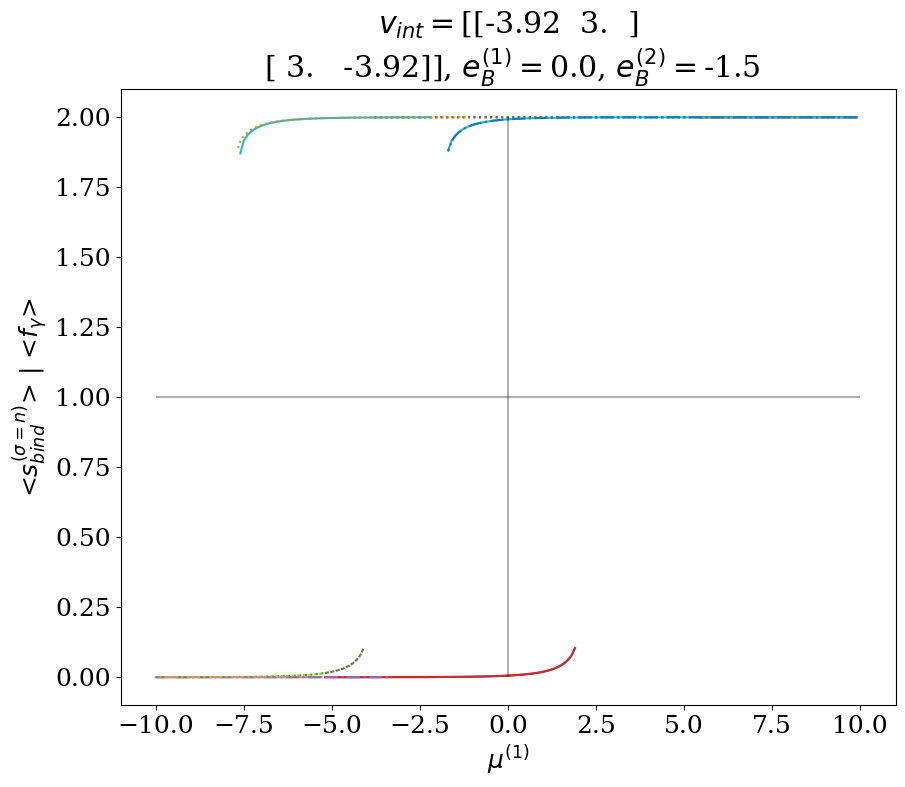

In [260]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

lins = ["-", ":", "-.", "--"]
# lins_bnd = [":", "-", "--", "-."]
# lins = ["-"]*6

colors = ["blue","orange","green","red", "pink", "purple"]
for k,x0 in enumerate(x0_arr[:]):

    if k <= 1:
        msg = ", ltr"
    else:
        msg = ", rtl"
    if k == 1 or k == 2:
        msg2 = ", $\mu_{start} = $"+ str(np.round(mu_mid,3))
    elif k == 0:
        msg2 =  ", $\mu_{start} = -10$"
    elif k ==3:
         msg2 = ", $\mu_{start} = 10$"
            
    plt.plot(mu_arrs[k], f_bar_arr_arr[k][0][:,0], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = 0$"+ msg +msg2, linestyle = lins[0])# + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
    plt.plot(mu_arrs[k], f_bar_arr_arr[k][0][:,1], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = 10$"+ msg +msg2,linestyle = lins[2])# + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
    plt.plot(mu_arrs[k], f_bar_arr_arr[k][0][:,2], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = -10$"+ msg +msg2,linestyle = lins[1])# + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
    
    
# plt.plot(mu1_array, f_bar1_arr[:,0], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = 0$", color = "blue")
# # plt.xlabel("$\mu$")
# # plt.ylabel("<$ f_{\gamma} $>")

# plt.plot(mu1_array, f_bar1_arr[:,1], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = 10$", color = "green", linestyle = "-.")

# plt.plot(mu1_array, f_bar1_arr[:,2], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = -10$", color = "red", linestyle = "--", zorder = 4)

# # plt.plot(mu1_array, f_bar_arr, label = "<$ f_{\gamma}^{(1)} $> single protein", color = "black")

# # LANGMUIR. Assumptions only valid when v_int = 0, and for sigma =0 or 2 (all sites identical)
# K = np.exp(-e_m[0])
# plt.plot(mu1_array, 2*K*np.exp(mu1_array) / (1+ K*np.exp(mu1_array)), label = "langmuir", linestyle = ":", color = "black")

# K = np.exp(-0)  # sigma = 0 - all binding energies are 0
# plt.plot(mu_array, 2*K*np.exp(mu_array) / (1+ K*np.exp(mu_array)), label = "langmuir, e_b = 0", linestyle = "-.", color = "black")

# plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
# plt.xlabel("$\mu$")

plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
plt.xlabel("$\mu^{(1)}$")
plt.title("$v_{int} = $" + str(v_int) +  ", $e_B^{(1)} = $" + str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]))
plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
# plt.legend()

# why is s_bind = 2 * (exp(x \ (1 + exp)))? how did that realtion come about. it is to allow for unbounded minimizationq
#check solver- intial conditions? 

In [ ]:
# TODO chi comparison!

In [ ]:
# # MULTIPLE STARTING CONDITIONS, UNBOUNDED
 
# mu_array = np.arange(-10, 10, .1)
# # mu_array = np.arange(-8, -3, 1)
# mul = len(mu_array)
# ones = np.ones(n_bind * 3)
# x0_min = -4
# x0_mid = 0
# x0_max = 4

# x0_arr = np.array([ones * x0_min, ones * x0_mid, ones*x0_mid, ones * x0_max])

# mu_mid = -5.25
# # mu_mid = -9


# mu_arrs = [mu_array, mu_array[np.where(mu_array >= mu_mid)], \
#            mu_array[np.where(mu_array <= mu_mid)][::-1], mu_array[::-1]]

# mu_fail_arr_arr = np.zeros(len(x0_arr), dtype = object)
# f_bar_arr_arr = np.zeros(len(x0_arr), dtype = object)

# for j,x0 in enumerate(x0_arr):
#     mu_ar = mu_arrs[j]
# #     print(j)
# #     print("mu arr [0]: ", mu_ar[0])
# #     print("x0[0] = ", x0[0])
#     f_bar_arr = np.zeros(len(mu_ar))
#     s_bind_0sig = np.zeros(len(mu_ar))
#     s_bind_1sig = np.zeros(len(mu_ar))
#     s_bind_2sig = np.zeros(len(mu_ar)) 
#     mu_fail_arr = np.array([])
#     x00 = x0
#     for i,mu in enumerate(mu_ar):
#         s_bind, mu_fail_arr = eval_s_bind([mu], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
#         f_bar = np.sum(f_om * s_bind)
#         s_bind_0sig[i] = s_bind[0]
#         s_bind_1sig[i] = s_bind[1]
#         s_bind_2sig[i] = s_bind[2]
#         f_bar_arr[i] = f_bar
#         if s_bind[0] is not np.nan:
#             x00 = -np.log( (2/s_bind) - 1)
   
#     f_bar_arr_arr[j] = f_bar_arr
#     mu_fail_arr_arr[j] = mu_fail_arr
# #     print("xxxxxxxxxx end of one iter xxxx")